# Task 1: Preprocess and Explore Financial Data
This notebook loads historical financial data, cleans it, performs exploratory data analysis (EDA), and computes key financial risk metrics.

## Import necessary libraries

In [6]:
import yfinance as yf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import norm
from sklearn.preprocessing import MinMaxScaler

# Set plot style for better visuals
sns.set(style='whitegrid')

## Fetch Historical Financial Data

In [9]:
# Define tickers and date range
tickers = ["TSLA", "BND", "SPY"]
start_date = "2015-01-01"
end_date = "2025-01-31"

# Fetch data using yfinance with explicit parameters
data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False)
print(f"✅ Data Fetched: {data.shape[0]} rows")
print("Column names:", data.columns)

# Extract Adjusted Close prices
adj_close = data['Adj Close']
adj_close.columns = tickers  # Simplify column names

# Save raw data
adj_close.to_csv('../data/raw/adj_close.csv')

# Display first few rows
adj_close.head()

[*********************100%***********************]  3 of 3 completed

✅ Data Fetched: 2535 rows
Column names: MultiIndex([('Adj Close',  'BND'),
            ('Adj Close',  'SPY'),
            ('Adj Close', 'TSLA'),
            (    'Close',  'BND'),
            (    'Close',  'SPY'),
            (    'Close', 'TSLA'),
            (     'High',  'BND'),
            (     'High',  'SPY'),
            (     'High', 'TSLA'),
            (      'Low',  'BND'),
            (      'Low',  'SPY'),
            (      'Low', 'TSLA'),
            (     'Open',  'BND'),
            (     'Open',  'SPY'),
            (     'Open', 'TSLA'),
            (   'Volume',  'BND'),
            (   'Volume',  'SPY'),
            (   'Volume', 'TSLA')],
           names=['Price', 'Ticker'])


,TSLA,BND,SPY
Date,,,
2015-01-02,62.387070,172.592850,14.620667
2015-01-05,62.568260,169.475906,14.006000
2015-01-06,62.749428,167.879608,14.085333
2015-01-07,62.787159,169.971573,14.063333
2015-01-08,62.689007,172.987762,14.041333



## Data Cleaning and Understanding

In [10]:
# Check basic statistics
print("Basic Statistics:")
display(adj_close.describe())

# Check data types
print("\nData Types:")
display(adj_close.dtypes)

# Check for missing values
print("\nMissing Values:")
display(adj_close.isnull().sum())

# Handle missing values with forward fill
adj_close = adj_close.ffill()

# Verify no missing values remain
print("\nMissing Values After Cleaning:")
display(adj_close.isnull().sum())

Basic Statistics:


,TSLA,BND,SPY
count,2535.000000,2535.000000,2535.000000
mean,69.083444,316.067402,117.848209
std,4.777899,117.926910,116.508288
min,61.677002,156.800827,9.578000
25%,65.370335,214.841988,17.228000
50%,68.125992,277.117828,30.298000
75%,72.663273,405.869202,221.525002
max,78.588928,609.750000,479.859985



Data Types:


TSLA    float64
BND     float64
SPY     float64
dtype: object


Missing Values:


TSLA    0
BND     0
SPY     0
dtype: int64


Missing Values After Cleaning:


TSLA    0
BND     0
SPY     0
dtype: int64

# Normalize the Data

In [12]:
# Normalize the data using MinMaxScaler
scaler = MinMaxScaler()
normalized_adj_close = pd.DataFrame(scaler.fit_transform(adj_close), 
                                    columns=adj_close.columns, 
                                    index=adj_close.index)

# Save normalized data
normalized_adj_close.to_csv('../data/processed/normalized_adj_close.csv')

# Display first few rows
normalized_adj_close.head()

,TSLA,BND,SPY
Date,,,
2015-01-02,0.041986,0.034865,0.010723
2015-01-05,0.052700,0.027983,0.009416
2015-01-06,0.063412,0.024459,0.009584
2015-01-07,0.065643,0.029078,0.009538
2015-01-08,0.059840,0.035737,0.009491


## EDA

### Visualize Closing Prices

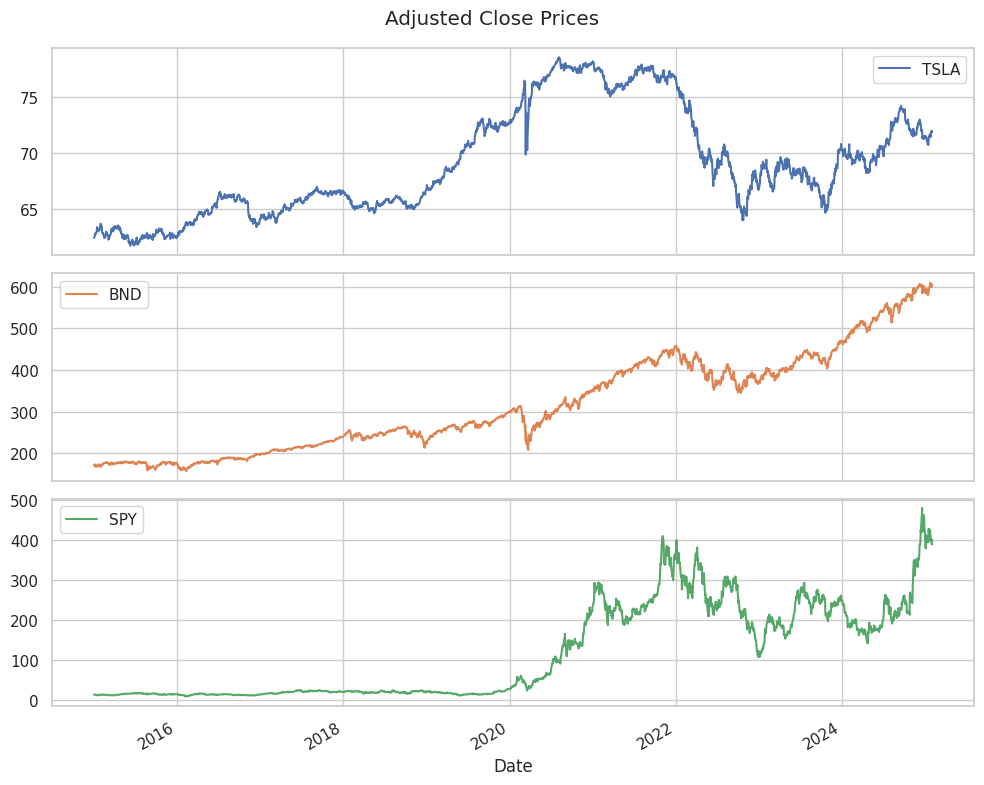

In [16]:
# Plot adjusted close prices
adj_close.plot(subplots=True, figsize=(10, 8), title="Adjusted Close Prices")
plt.tight_layout()
plt.savefig('../figs/adj_close.png')
plt.show()

### Calculate and Plot Daily Returns

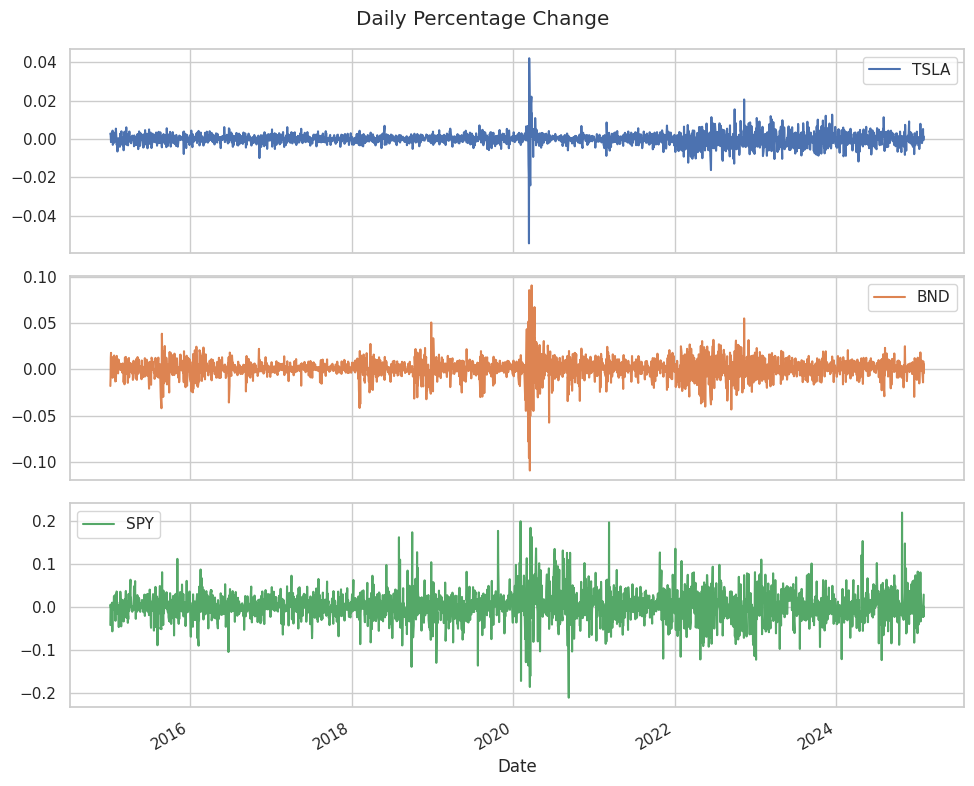

In [17]:
# Calculate daily percentage change
daily_returns = adj_close.pct_change()

# Plot daily returns
daily_returns.plot(subplots=True, figsize=(10, 8), title="Daily Percentage Change")
plt.tight_layout()
plt.savefig('../figs/daily_returns.png')
plt.show()

### Analyze Volatility with Rolling Statistics

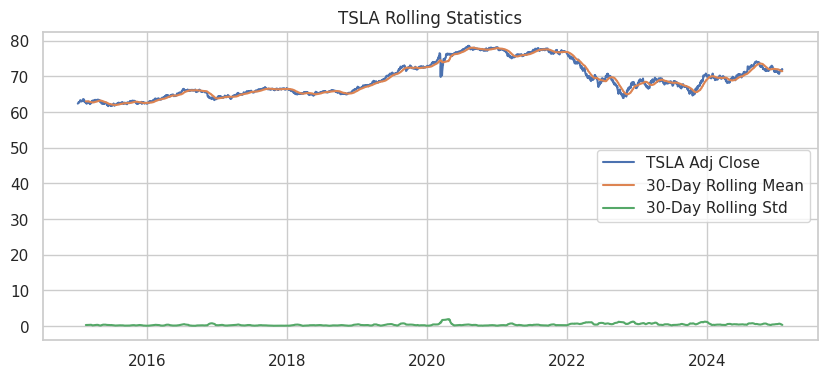

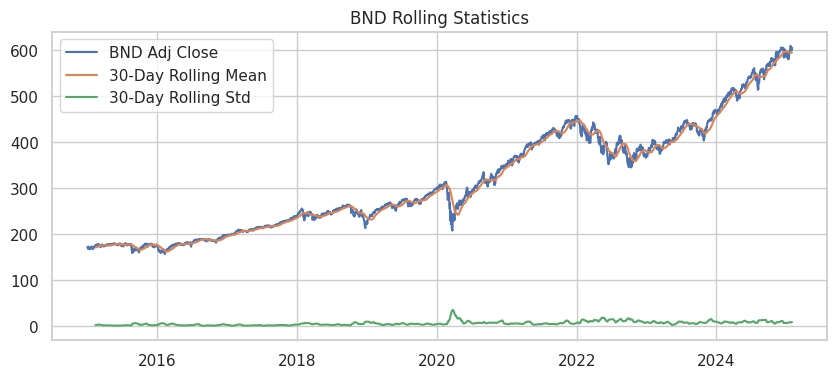

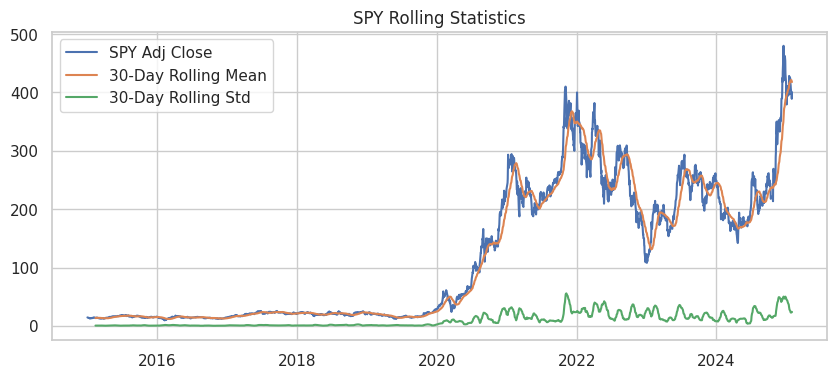

In [18]:
# Plot rolling mean and standard deviation for each ticker
for ticker in tickers:
    rolling_mean = adj_close[ticker].rolling(window=30).mean()
    rolling_std = adj_close[ticker].rolling(window=30).std()
    
    plt.figure(figsize=(10, 4))
    plt.plot(adj_close[ticker], label=f'{ticker} Adj Close')
    plt.plot(rolling_mean, label='30-Day Rolling Mean')
    plt.plot(rolling_std, label='30-Day Rolling Std')
    plt.title(f'{ticker} Rolling Statistics')
    plt.legend()
    plt.savefig(f'../figs/rolling_stats_{ticker}.png')
    plt.show()

### Outlier Detection

In [19]:
# Detect outliers in daily returns
for ticker in tickers:
    returns = adj_close[ticker].pct_change()
    mean_return = returns.mean()
    std_return = returns.std()
    outliers = returns[(returns < mean_return - 3*std_return) | 
                       (returns > mean_return + 3*std_return)]
    print(f"Outliers in {ticker} Daily Returns:\n{outliers.dropna()}\n")

Outliers in TSLA Daily Returns:
Date
2020-03-10   -0.013444
2020-03-11   -0.018940
2020-03-12   -0.054385
2020-03-13    0.042201
2020-03-16    0.010511
2020-03-17   -0.020685
2020-03-18   -0.024140
2020-03-20    0.016955
2020-03-23    0.022150
2020-03-25    0.013440
2020-04-09    0.010979
2022-03-02   -0.012284
2022-03-21   -0.010227
2022-06-13   -0.016153
2022-06-15    0.011460
2022-08-05   -0.011318
2022-09-22   -0.010281
2022-09-26   -0.012778
2022-09-28    0.015544
2022-11-10    0.020703
2023-01-06    0.011027
2023-03-10    0.011976
2023-03-27   -0.010382
2023-05-01   -0.010284
2023-11-14    0.012202
2023-12-13    0.012771
2024-04-10   -0.011686
2024-08-02    0.011418
Name: TSLA, dtype: float64

Outliers in BND Daily Returns:
Date
2015-08-24   -0.042107
2015-08-26    0.038394
2016-06-24   -0.035909
2018-02-05   -0.041822
2018-02-08   -0.037509
2018-12-26    0.050525
2020-02-24   -0.033166
2020-02-27   -0.044912
2020-03-02    0.043306
2020-03-04    0.042033
2020-03-05   -0.033242
20

### Seasonality and Trends

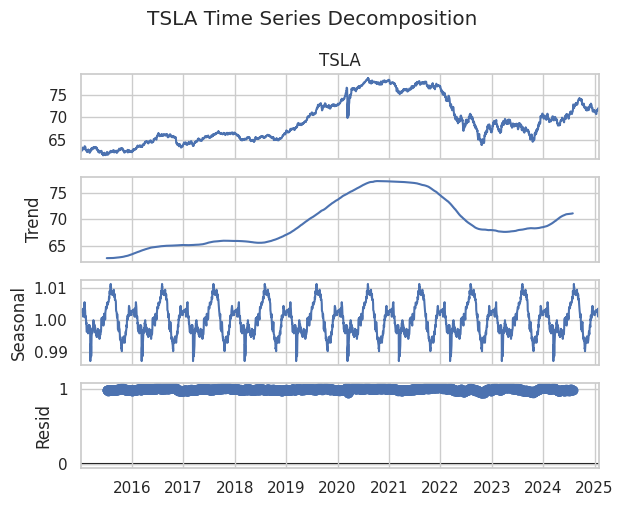

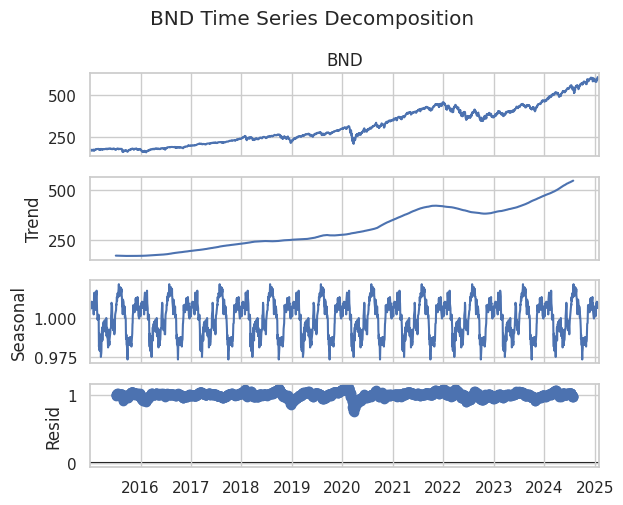

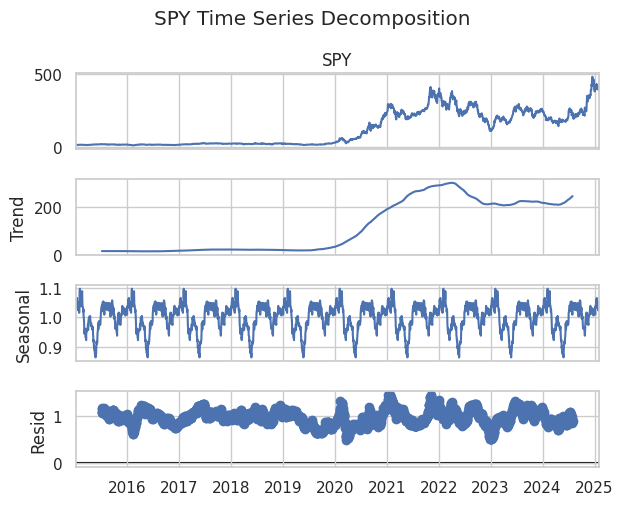

In [20]:
# Decompose time series for seasonality and trends
for ticker in tickers:
    decomposition = seasonal_decompose(adj_close[ticker], model='multiplicative', period=252)
    decomposition.plot()
    plt.suptitle(f'{ticker} Time Series Decomposition', y=1.05)
    plt.savefig(f'../figs/decomposition_{ticker}.png')
    plt.show()

## Analyze Volatility

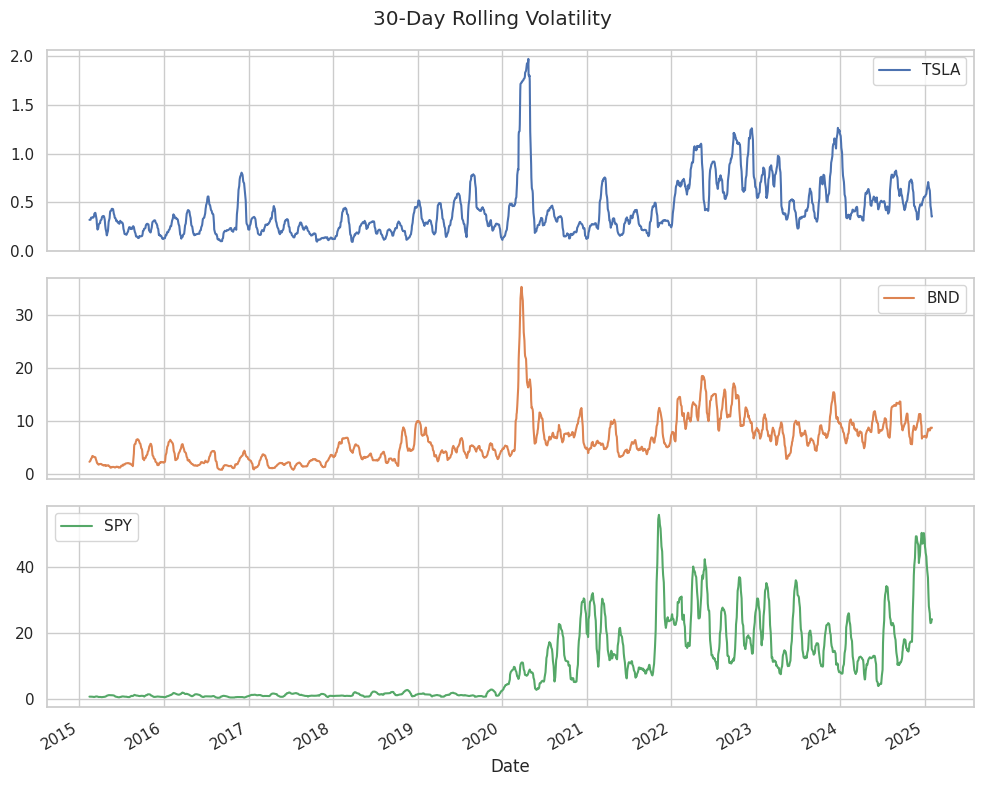

In [21]:
# Plot 30-day rolling volatility
rolling_std = adj_close.rolling(window=30).std()
rolling_std.plot(subplots=True, figsize=(10, 8), title="30-Day Rolling Volatility")
plt.tight_layout()
plt.savefig('../figs/rolling_volatility.png')
plt.show()

## Calculate Risk Metrics

In [22]:
# Calculate VaR and Sharpe Ratio
for ticker in tickers:
    returns = adj_close[ticker].pct_change().dropna()
    
    # Value at Risk (VaR) at 95% confidence
    VaR_95 = norm.ppf(0.05, returns.mean(), returns.std())
    
    # Sharpe Ratio (assuming 2% risk-free rate)
    annual_return = (1 + returns.mean())**252 - 1
    annual_volatility = returns.std() * np.sqrt(252)
    risk_free_rate = 0.02
    sharpe_ratio = (annual_return - risk_free_rate) / annual_volatility
    
    print(f"\nRisk Metrics for {ticker}:")
    print(f"  - VaR (95%): {VaR_95:.4f}")
    print(f"  - Sharpe Ratio: {sharpe_ratio:.4f}")


Risk Metrics for TSLA:
  - VaR (95%): -0.0056
  - Sharpe Ratio: -0.0764

Risk Metrics for BND:
  - VaR (95%): -0.0177
  - Sharpe Ratio: 0.7423

Risk Metrics for SPY:
  - VaR (95%): -0.0573
  - Sharpe Ratio: 1.0755
